<a href="https://colab.research.google.com/github/Mariem222/DataAnalysis/blob/main/Unet_experience.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from osgeo import gdal
import numpy as np
import cv2

# Load the bands
red = gdal.Open("B4.tiff").ReadAsArray()
green = gdal.Open("B3.tiff").ReadAsArray()
blue = gdal.Open("B2.tiff").ReadAsArray()

# Stack bands into RGB image
rgb = np.stack([red, green, blue], axis=-1)
rgb = (rgb / np.max(rgb) * 255).astype(np.uint8)

# Save as RGB image
cv2.imwrite("sentinel2_rgb.png", rgb)


True

In [2]:
!apt update -qq
!apt install -qq gdal-bin python3-gdal

33 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  libgdal-grass python-numpy-doc python3-pytest
The following NEW packages will be installed:
  gdal-bin python3-gdal python3-numpy
0 upgraded, 3 newly installed, 0 to remove and 33 not upgraded.
Need to get 5,055 kB of archives.
After this operation, 25.1 MB of additional disk space will be used.
Selecting previously unselected package python3-numpy.
(Reading database ... 124947 files and directories currently installed.)
Preparing to unpack .../python3-numpy_1%3a1.21.5-1ubuntu22.04.1_amd64.deb ...
Unpacking python3-numpy (1:1.21.5-1ubuntu22.04.1) ...
Selecting previously unselected package python3-gdal.
Preparing to unpack .../python3-gdal_3.

In [8]:
!gdalwarp -tr 0.001 0.001 -r cubic B11.tiff B11_resampled.tif


Creating output file that is 497P x 390L.
Processing B11.tiff [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


In [9]:
import cv2
import numpy as np

image = cv2.imread("sentinel2_rgb.png").astype(np.float32) / 255.0


In [10]:
from tensorflow.keras.preprocessing.image import img_to_array

def crop_image(image, size=256):
    h, w, _ = image.shape
    patches = []
    for i in range(0, h, size):
        for j in range(0, w, size):
            patch = image[i:i+size, j:j+size]
            if patch.shape[:2] == (size, size):  # Ensure all patches are same size
                patches.append(patch)
    return np.array(patches)

patches = crop_image(image)


In [11]:
import torch
from torchvision import transforms
from PIL import Image

model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
model.eval()

img = Image.open("sentinel2_rgb.png").convert("RGB")
preprocess = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])
input_tensor = preprocess(img).unsqueeze(0)

with torch.no_grad():
    output = model(input_tensor)["out"][0]
mask = (output.argmax(0) == 1).numpy().astype("uint8") * 255
Image.fromarray(mask).save("road_mask.tif")


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 181MB/s]


In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_data(image_path, mask_path, img_size=(256, 256)):
    img = load_img(image_path, target_size=img_size, color_mode="rgb")
    mask = load_img(mask_path, target_size=img_size, color_mode="grayscale")

    img = img_to_array(img) / 255.0
    mask = img_to_array(mask) / 255.0  # Ensure binary values 0 or 1

    return img, mask

image, mask = load_data("sentinel2_rgb.png", "road_mask.tif")


In [23]:
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2

def build_unet(input_shape=(256, 256, 3)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(inputs)
    c1 = layers.BatchNormalization()(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    p1 = layers.Dropout(0.3)(p1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(p1)
    c2 = layers.BatchNormalization()(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    p2 = layers.Dropout(0.3)(p2)

    # Bottleneck
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Dropout(0.3)(c3)

    # Decoder
    u4 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c3)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(u4)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Dropout(0.3)(c4)

    u5 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c4)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(u5)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Dropout(0.3)(c5)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = build_unet()


In [24]:
import numpy as np
import cv2

def crop_image(image, mask, size=256):
    h, w, _ = image.shape
    patches_img = []
    patches_mask = []

    # Padding the image and mask to ensure they are divisible by the patch size
    pad_h = (size - h % size) % size
    pad_w = (size - w % size) % size
    image_padded = np.pad(image, ((0, pad_h), (0, pad_w), (0, 0)), mode='constant')
    mask_padded = np.pad(mask, ((0, pad_h), (0, pad_w)), mode='constant')

    # Iterate over the padded image and mask to extract patches
    for i in range(0, image_padded.shape[0], size):
        for j in range(0, image_padded.shape[1], size):
            patch_img = image_padded[i:i+size, j:j+size]
            patch_mask = mask_padded[i:i+size, j:j+size]

            # Ensure both patches are of the correct shape
            if patch_img.shape == (size, size, 3) and patch_mask.shape == (size, size):
                patches_img.append(patch_img)
                patches_mask.append(patch_mask)

    # Convert lists to arrays only if they are consistent
    patches_img = np.array(patches_img)
    patches_mask = np.array(patches_mask)

    # Check that all patches have the expected shape
    print(f"Shape of patches_img: {patches_img.shape}")
    print(f"Shape of patches_mask: {patches_mask.shape}")

    return patches_img, patches_mask

# Crop the image and mask into smaller patches for training
X, Y = crop_image(image, mask, size=256)

# Split the data into training and validation sets (80% train, 20% validation)
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


Shape of patches_img: (4, 256, 256, 3)
Shape of patches_mask: (4, 256, 256)


In [25]:
model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=50, batch_size=16)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.4966 - loss: 5.4751 - val_accuracy: 1.0000 - val_loss: 5.0094
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4883 - loss: 5.2195 - val_accuracy: 1.0000 - val_loss: 4.8057
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.4859 - loss: 4.9279 - val_accuracy: 1.0000 - val_loss: 4.5998
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.4948 - loss: 4.6902 - val_accuracy: 1.0000 - val_loss: 4.3939
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.5175 - loss: 4.4726 - val_accuracy: 1.0000 - val_loss: 4.1909
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.5447 - loss: 4.2605 - val_accuracy: 1.0000 - val_loss: 3.9923
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.5710 - loss: 4.0571 - val_accuracy: 1.0000 - val_loss: 3.7991
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.5923 - loss: 3.8636 - val_accuracy: 1.0000 - val_loss: 3.6

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step


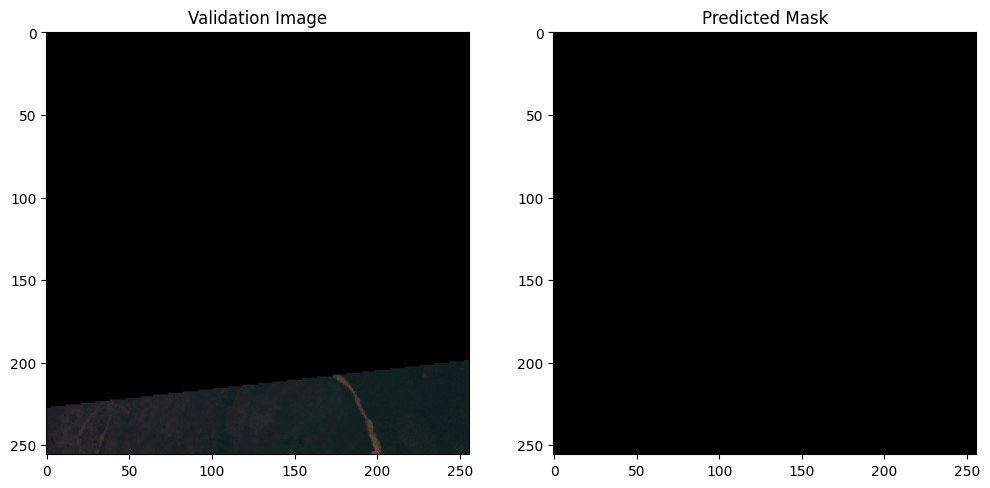

In [26]:
import matplotlib.pyplot as plt

# Predict masks for the validation set
predicted_masks = model.predict(X_val)

# If the model uses sigmoid activation, apply thresholding to get binary masks
# Adjust the threshold as needed (e.g., 0.5)
predicted_masks_binary = (predicted_masks > 0.5).astype(np.uint8)

# Visualize the predicted mask for the first image in the validation set
plt.figure(figsize=(12, 6))

# Display the first image in the validation set
plt.subplot(1, 2, 1)
plt.imshow(X_val[0])  # Display the first validation image
plt.title('Validation Image')

# Display the corresponding predicted mask
plt.subplot(1, 2, 2)
plt.imshow(predicted_masks_binary[0], cmap='gray')  # Display the predicted mask for the first image
plt.title('Predicted Mask')

plt.show()


In [15]:
!ls


B11_resampled.tif  B2.tiff  B4.tiff	   sample_data
B11.tiff	   B3.tiff  road_mask.tif  sentinel2_rgb.png
